---
title: Fig. S21 - Cog categories in Spectral Tree
author: Benjamin Doran
date: today
---

In [1]:
#| code-fold: true
#| code-summary: Julia Setup
#| output: false

using DrWatson
@quickactivate projectdir()

using CSV, Muon, DataFrames
using Chain
using StatsBase
using SpectralInference, NewickTree
using StatsPlots
theme(:default, grid=false, label=false, tickdir=:out)

pdir = plotsdir("reviewer_plots") |> mkpath
rdir = projectdir("_research", "strain_variation_wilcoxon_tests") |> mkpath

"/Users/bend/projects/Doran_etal_2023/_research/strain_variation_wilcoxon_tests"

In [2]:
uniprot = readh5ad(datadir("exp_raw", "UP7047", "2020_02_UP7047.h5ad"))
biobank = readh5mu(datadir("exp_raw", "BB669", "BB669.h5mu"))

┌ Warning: Cannot join columns with the same name because var_names are intersecting.
└ @ Muon /Users/bend/.julia/packages/Muon/UKjAF/src/mudata.jl:367


MuData object 669 ✕ 21475
└ metabolites_foldchange
  AnnData object 669 ✕ 50
└ oggs
  AnnData object 669 ✕ 11248
└ UPorder_oggs
  AnnData object 669 ✕ 10177

In [4]:
upmtx = uniprot.X[:, :]
upusv = svd(upmtx)
bbmtx = biobank["UPorder_oggs"].X[:,:]
@show size(bbmtx)
keptspecies = sort(filter(x-> last(x) >= 20, countmap(biobank.obs.Species)), byvalue=true, rev=true)
filter!(!=("unclassified"), keptspecies)
# species => number of strains belonging to that species

size(bbmtx) = (669, 10177)


OrderedCollections.OrderedDict{String, Int64} with 12 entries:
  "Phocaeicola vulgatus"         => 88
  "[Ruminococcus] gnavus"        => 41
  "Bacteroides thetaiotaomicron" => 35
  "Anaerostipes hadrus"          => 31
  "Bacteroides uniformis"        => 27
  "unclassified"                 => 26
  "Blautia luti"                 => 24
  "Bifidobacterium breve"        => 24
  "Coprococcus comes"            => 23
  "Dorea formicigenerans"        => 22
  "Blautia wexlerae"             => 21
  "[Eubacterium] rectale"        => 20

## Tree plot

In [27]:
strvarmtx = bbmtx[biobank.obs.kept_species.==1,:];
@show size(strvarmtx)

strvarobs = biobank.obs[biobank.obs.kept_species.==1, :]
strvar_obsnames = strvarobs.Strain_ID

# infer hierarchical relationships of just the species with
# greater than 20 strain replicates
uhat = projectinLSV(strvarmtx, upusv)
dij = spectraldistances(uhat, upusv.S; alpha=1.5, q=.75) ./ size(uniprot, 2)
strvartree_hc = UPGMA_tree(dij)
strvartree = readnw(SpectralInference.newickstring(strvartree_hc, strvar_obsnames))
# ladderize!(strvartree)

size(strvarmtx) = (356, 10177)


(((((((DFI.1.247:0.003931399,DFI.1.135:0.003931399):0.0261128,DFI.1.173:0.0300442):1.102017,MSK.17.15:1.132061):0.4641554,((((((MSK.19.71:0.001116743,(MSK.19.54:0.0001738008,MSK.19.4:0.0001738008):0.0009429425):0.001027894,MSK.19.91:0.002144637):0.0006451383,MSK.19.84:0.002789775):0.9853182,(MSK.20.30:0.03613531,(MSK.20.3:0.009151378,MSK.20.79:0.009151378):0.02698393):0.9519726):0.01828051,(MSK.16.71:0.1179327,(MSK.16.7:0.06787214,(MSK.16.46:0.001618285,(MSK.16.44:0.0001595074,MSK.16.39:0.0001595074):0.001458778):0.06625386):0.05006053):0.8884558):0.1753671,((DFI.3.57:0.9677974,((MSK.18.66:0.001366842,(((MSK.18.33:2.82369e-17,MSK.18.78:2.82369e-17):0.000426245,((MSK.18.89:3.029125e-17,MSK.18.30:3.029125e-17):0.0,MSK.18.25:3.029125e-17):0.000426245):0.0002283746,MSK.18.77:0.0006546196):0.0007122219):0.0002409801,MSK.18.74:0.001607822):0.9661896):0.1983591,DFI.4.149:1.166157):0.01559899):0.414461):1.683172,((((DFI.3.23:0.1084715,((((DFI.1.133:0.002279274,DFI.1.35:0.002279274):0.000599515

In [6]:
countmap(strvarobs.NCBI_Phylum)

Dict{String, Int64} with 3 entries:
  "Firmicutes"     => 182
  "Bacteroidetes"  => 150
  "Actinobacteria" => 24

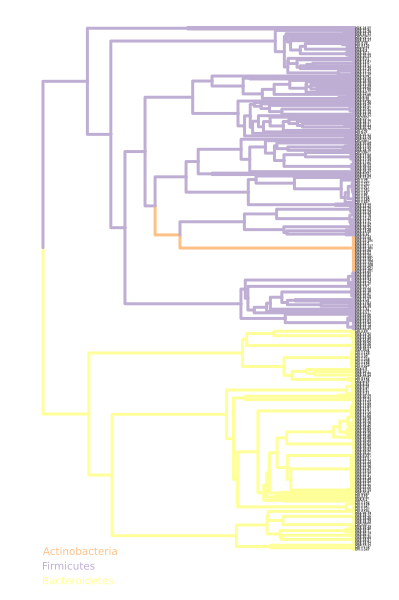

In [7]:
phylum_color_dict = Dict(k=>v for (k,v) in zip(unique(strvarobs.NCBI_Phylum), palette(:Accent)[[4,2,3]]));
phylum_linecolors = map(prewalk(strvartree)) do node; strvarobs, strvar_obsnames, phylum_color_dict
    leafids = getleafnames(node)
    leafphylum = strvarobs.NCBI_Phylum[indexin(leafids, strvar_obsnames)]
    get(phylum_color_dict, mode(leafphylum), :grey)
end |> x->x[2:end] |> permutedims

plot(strvartree,
    fs=2, rightmargin=7Plots.mm,
    c=phylum_linecolors,
    lw=3,
    size=(400, 600),
)
# phyla 
for (i, (k,v)) in enumerate(zip(unique(strvarobs.NCBI_Phylum), palette(:Accent)[[4,2,3]]))
    annotate!(0, i*10 - 30, text(k, 7, :left, :black,v), c=v)
end
plot!()

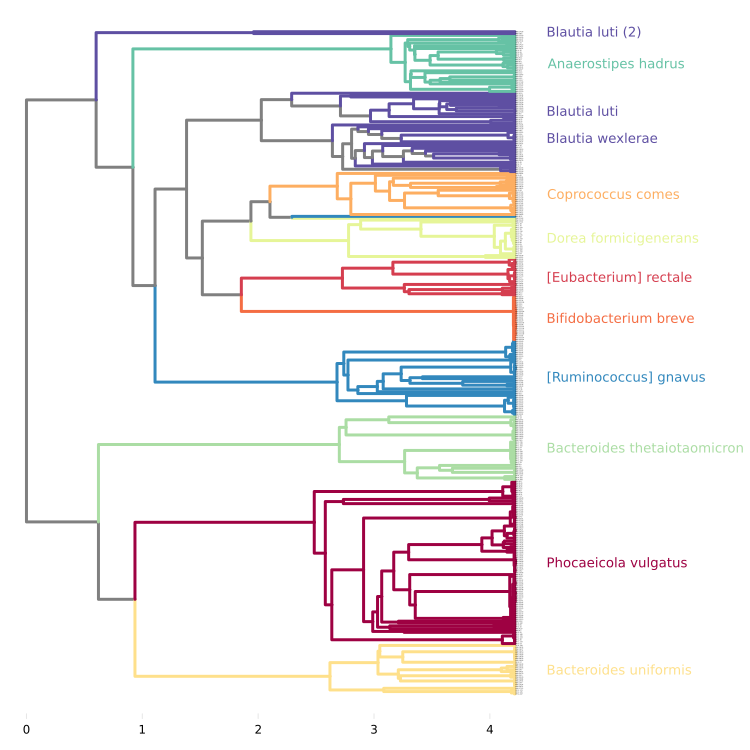

In [36]:
speciescolordf = CSV.read(datadir("exp_raw","BB669","subsettreecolors.csv"), DataFrame)
species_color_dict = Dict(k=>v for (k,v) in zip(speciescolordf.species_name, speciescolordf.color));
speciesvector = strvarobs.Species[indexin(getleafnames(strvartree), strvar_obsnames)];
species_linecolors = map(prewalk(strvartree)) do node; strvarobs, strvar_obsnames, species_color_dict
    leafids = getleafnames(node)
    leafspecies = strvarobs.Species[indexin(leafids, strvar_obsnames)]
    if length(unique(leafspecies)) == 1
        get(species_color_dict, mode(leafspecies), :grey)
    else
        :grey
    end
end |> x->x[2:end] |> permutedims

 plot(strvartree,
    yticks=false,
    fs=1, rightmargin=5.4Plots.cm,
    c=species_linecolors,
    lw=3, size=(750, 750),
    framestyle=:grid,
)
# species 
for (i, (k,v)) in enumerate(zip(speciescolordf.species_name, speciescolordf.color))
    yval = median(findall(==(k), speciesvector))
    annotate!(4.5, yval, text(k, 9, :left, v))
end
annotate!(4.5, 356, text("Blautia luti (2)", 9, :left, species_color_dict["Blautia luti"]))
# vline!([.5,2.5])
fancy_tree_plot = plot!()

In [9]:
savefig(joinpath(pdir, "str_var_tree_colored_by_species.pdf"));

## OGG annotations to COG groups

In [10]:
testresults = CSV.read(joinpath(rdir, "full_ogg_wilcoxon_testresults_on_big10species.csv"), DataFrame);
sigtestresults = filter(:qval_BH => <(0.05), testresults) |>
      df -> filter(:logeffectsize => >(1), df) |>
      df -> filter(:effectsize => >(1), df) |>
      df -> filter(:log2FC => x -> abs.(x) .> 1, df);

In [11]:
first(sigtestresults, 5)

5×26 DataFrame
 Row │ nodeids  nodeheight  nodedepth  grp1_N  grp2_N  grp1_phylum_mode  grp2_ ⋯
     │ Int64    Float64     Float64    Int64   Int64   String15          Strin ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │       1         0.0    4.21594     150     206  Bacteroidetes     Firmi ⋯
   2 │       1         0.0    4.21594     150     206  Bacteroidetes     Firmi
   3 │       1         0.0    4.21594     150     206  Bacteroidetes     Firmi
   4 │       1         0.0    4.21594     150     206  Bacteroidetes     Firmi
   5 │       1         0.0    4.21594     150     206  Bacteroidetes     Firmi ⋯
                                                              20 columns omitted

* CELLULAR PROCESSES AND SIGNALING
    * [D] Cell cycle control, cell division, chromosome partitioning
    * [M] Cell wall/membrane/envelope biogenesis
    * [N] Cell motility
    * [O] Post-translational modification, protein turnover, and chaperones
    * [T] Signal transduction mechanisms
    * [U] Intracellular trafficking, secretion, and vesicular transport
    * [V] Defense mechanisms
    * [W] Extracellular structures
    * [Y] Nuclear structure
    * [Z] Cytoskeleton
* INFORMATION STORAGE AND PROCESSING
    * [A] RNA processing and modification
    * [B] Chromatin structure and dynamics
    * [J] Translation, ribosomal structure and biogenesis
    * [K] Transcription
    * [L] Replication, recombination and repair
* METABOLISM
    * [C] Energy production and conversion
    * [E] Amino acid transport and metabolism
    * [F] Nucleotide transport and metabolism
    * [G] Carbohydrate transport and metabolism
    * [H] Coenzyme transport and metabolism
    * [I] Lipid transport and metabolism
    * [P] Inorganic ion transport and metabolism
    * [Q] Secondary metabolites biosynthesis, transport, and catabolism
* POORLY CHARACTERIZED
    * [R] General function prediction only
    * [S] Function unknown

In [12]:
COG_cat_desc_map = Dict(
    'D' => "Cell cycle control, cell division, chromosome partitioning",
    'M' => "Cell wall/membrane/envelope biogenesis",
    'N' => "Cell motility",
    'O' => "Post-translational modification, protein turnover, and chaperones",
    'T' => "Signal transduction mechanisms",
    'U' => "Intracellular trafficking, secretion, and vesicular transport",
    'V' => "Defense mechanisms",
    'W' => "Extracellular structures",
    'Y' => "Nuclear structure",
    'Z' => "Cytoskeleton",
    'A' => "RNA processing and modification",
    'B' => "Chromatin structure and dynamics",
    'J' => "Translation, ribosomal structure and biogenesis",
    'K' => "Transcription",
    'L' => "Replication, recombination and repair",
    'C' => "Energy production and conversion",
    'E' => "Amino acid transport and metabolism",
    'F' => "Nucleotide transport and metabolism",
    'G' => "Carbohydrate transport and metabolism",
    'H' => "Coenzyme transport and metabolism",
    'I' => "Lipid transport and metabolism",
    'P' => "Inorganic ion transport and metabolism",
    'Q' => "Secondary metabolites biosynthesis, transport, and catabolism",
    'R' => "General function prediction only",
    'S' => "Function unknown",
)
COG_cat_group_map = Dict(
    'D' => "CELLULAR PROCESSES AND SIGNALING",
    'M' => "CELLULAR PROCESSES AND SIGNALING",
    'N' => "CELLULAR PROCESSES AND SIGNALING",
    'O' => "CELLULAR PROCESSES AND SIGNALING",
    'T' => "CELLULAR PROCESSES AND SIGNALING",
    'U' => "CELLULAR PROCESSES AND SIGNALING",
    'V' => "CELLULAR PROCESSES AND SIGNALING",
    'W' => "CELLULAR PROCESSES AND SIGNALING",
    'Y' => "CELLULAR PROCESSES AND SIGNALING",
    'Z' => "CELLULAR PROCESSES AND SIGNALING",
    'A' => "INFORMATION STORAGE AND PROCESSING",
    'B' => "INFORMATION STORAGE AND PROCESSING",
    'J' => "INFORMATION STORAGE AND PROCESSING",
    'K' => "INFORMATION STORAGE AND PROCESSING",
    'L' => "INFORMATION STORAGE AND PROCESSING",
    'C' => "METABOLISM",
    'E' => "METABOLISM",
    'F' => "METABOLISM",
    'G' => "METABOLISM",
    'H' => "METABOLISM",
    'I' => "METABOLISM",
    'P' => "METABOLISM",
    'Q' => "METABOLISM",
    'R' => "UNKNOWN FUNCTION",
    'S' => "UNKNOWN FUNCTION",
);

In [13]:
ogg_annotations =
    @chain begin
        CSV.read(datadir("exp_raw", "UP7047", "2_annotations.tsv"), DataFrame)
        coalesce.("")
        select(Not(:level))
        transform(
            :category => ByRow(x -> !contains(x, r"S|R")) => :isannotated,
            :category => ByRow(x-> join(unique([COG_cat_desc_map[c] for c in x]), " & ")) => :category_description,
            :category => ByRow(x-> join(unique([COG_cat_group_map[c] for c in x]), " & ")) => :category_group,
        )
    end

206782×6 DataFrame
    Row │ ogg_name  category  description                        isannotated   ⋯
        │ String7   String7   String                             Bool          ⋯
────────┼───────────────────────────────────────────────────────────────────────
      1 │ 2Z7HP     S         Tocopherol cyclase                       false   ⋯
      2 │ 2Z7HQ     S         Protein of unknown function (DUF…        false
      3 │ 2Z7HR     S         Domain of unknown function (DUF4…        false
      4 │ 2Z7HS     S         Psort location CytoplasmicMembra…        false
      5 │ 2Z7HT     S         Protein of unknown function (DUF…        false   ⋯
      6 │ 2Z7HU     S                                                  false
      7 │ 2Z7HV     S                                                  false
      8 │ 2Z7HW     S         InterPro IPR010496                       false
   ⋮    │    ⋮         ⋮                      ⋮                       ⋮        ⋱
 206776 │ COG5659   L         transposition                             true   ⋯
 206777 │ COG5660   K         integral membrane protein                 true
 206778 │ COG5661   O         secreted Zn-dependent protease            true
 206779 │ COG5662   K         AntiSigma factor                          true
 206780 │ COG5663   F         Belongs to the 5'(3')-deoxyribon…         true   ⋯
 206781 │ COG5664   O         Bacterial protein of unknown fun…         true
 206782 │ COG5665   L         phosphatidylcholine phospholipas…         true
                                               2 columns and 206767 rows omitted

In [14]:
df = leftjoin(
    select(sigtestresults, [:nodeids, :nodeheight, :tree_level, :ogg_name,]),
    ogg_annotations,
    on=:ogg_name,
)
pltdf =
    @chain df begin
        coalesce.("")
        groupby(:tree_level)
        combine(:isannotated => mean)
    end

3×2 DataFrame
 Row │ tree_level     isannotated_mean 
     │ String15       Float64          
─────┼─────────────────────────────────
   1 │ phylum level           0.838554
   2 │ species level          0.821844
   3 │ strain level           0.571963

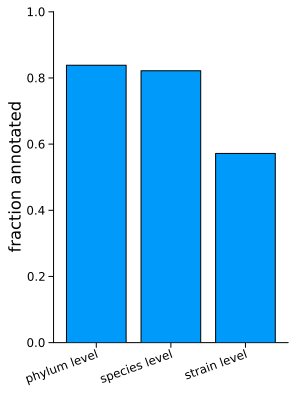

In [15]:
@df pltdf bar(:tree_level, :isannotated_mean,
    ylims=(0,1),
    size=(300, 400),
    xrotation=20,
    ylabel="fraction annotated",
)

In [16]:
savefig(joinpath(pdir, "fraction_oggs_annotated_allnodes.pdf"))

"/Users/bend/projects/Doran_etal_2023/plots/reviewer_plots/fraction_oggs_annotated_allnodes.pdf"

# Acetate specific annotations

In [17]:
strvar_tree = readnw(open(readline, datadir("exp_pro","BB669","strvar-spitree.nw")));

In [18]:
met_mtx = biobank["metabolites_foldchange"][:, "Acetate_rel"].X;
met_ids = biobank.obs_names;

In [19]:
# nodes where the average change in aceate is 2 times higher in one group vs the other
acetate_differences =
    map(prewalk(strvar_tree)) do node
        (isleaf(node) || any(isleaf.(children(node)))) && return missing
        nodeid = id(node)
        g1 = met_mtx[indexin(getleafnames(node[1]), met_ids)]
        g2 = met_mtx[indexin(getleafnames(node[2]), met_ids)]
        effect = abs(mean(g1) - mean(g2))
        return (; nodeid, effect)
    end |> skipmissing |> DataFrame |> df -> (filter(:effect => >=(1), df))

12×2 DataFrame
 Row │ nodeid  effect  
     │ UInt16  Float64 
─────┼─────────────────
   1 │      2  1.10003
   2 │     88  1.97374
   3 │    136  1.28064
   4 │    302  3.38908
   5 │    383  1.43674
   6 │    385  2.48998
   7 │    435  1.39884
   8 │    483  1.31227
   9 │    491  1.04347
  10 │    631  1.15746
  11 │    649  1.111
  12 │    685  1.02646

In [20]:
@chain sigtestresults begin
    subset(:nodeids => ByRow(∈(acetate_differences.nodeid)))
    @aside @info "number of sig oggs: $(nrow(_)); over $(length(unique(_.nodeids))) unique nodes: $(unique(_.nodeids))" 
    groupby([:tree_level, :nodeids]) 
    combine(nrow)
    sort(:nrow, rev=true)
end

┌ Info: number of sig oggs: 728; over 10 unique nodes: [2, 88, 136, 302, 383, 385, 435, 631, 649, 685]
└ @ Main /Users/bend/projects/Doran_etal_2023/notebooks/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_X21sZmlsZQ==.jl:3


10×3 DataFrame
 Row │ tree_level     nodeids  nrow  
     │ String15       Int64    Int64 
─────┼───────────────────────────────
   1 │ species level      385    296
   2 │ species level        2    118
   3 │ species level      302    113
   4 │ species level      383     82
   5 │ strain level       435     41
   6 │ strain level       136     38
   7 │ strain level        88     17
   8 │ strain level       685     11
   9 │ strain level       631      7
  10 │ strain level       649      5

In [22]:
colordict = Dict(
    k => v for (k, v) in zip(sort(unique(ogg_annotations.category_group)), palette(:seaborn_colorblind))
)

Dict{String, RGB{Float64}} with 10 entries:
  "CELLULAR PROCESSES AND SIGNALIN… => RGB{Float64}(0.00392157,0.45098,0.698039)
  "INFORMATION STORAGE AND PROCESS… => RGB{Float64}(0.792157,0.568627,0.380392)
  "CELLULAR PROCESSES AND SIGNALIN… => RGB{Float64}(0.870588,0.560784,0.0196078)
  "INFORMATION STORAGE AND PROCESS… => RGB{Float64}(0.8,0.470588,0.737255)
  "METABOLISM"                      => RGB{Float64}(0.984314,0.686275,0.894118)
  "CELLULAR PROCESSES AND SIGNALIN… => RGB{Float64}(0.00784314,0.619608,0.45098)
  "UNKNOWN FUNCTION"                => RGB{Float64}(0.337255,0.705882,0.913725)
  "METABOLISM & INFORMATION STORAG… => RGB{Float64}(0.92549,0.882353,0.2)
  "INFORMATION STORAGE AND PROCESS… => RGB{Float64}(0.835294,0.368627,0.0)
  "METABOLISM & CELLULAR PROCESSES… => RGB{Float64}(0.580392,0.580392,0.580392)

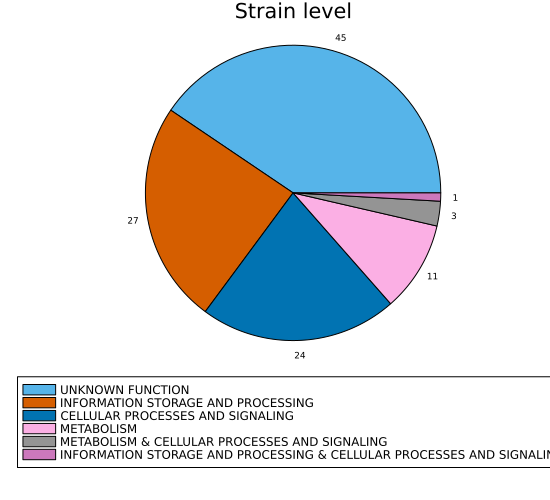

In [23]:
strain_level_acetate_oggs =
    @chain sigtestresults begin
        subset(
            :nodeids => ByRow(∈(acetate_differences.nodeid)),
            :tree_level => ByRow(==("strain level")),
        )
        # select([:nodeids, :grp1_N, :grp2_N, :ogg_name])
        select([:ogg_name])
        groupby(:ogg_name)
        combine(nrow)
        leftjoin(ogg_annotations, on=:ogg_name)
        unique
        # subset(:isannotated => ByRow(==(true)))
        sort([:nrow, :category, :ogg_name])
        # groupby([:nodeids])
        # combine(:isannotated => mean)
    end

labs, vals =
    @chain begin
        countmap(strain_level_acetate_oggs.category_group)
        sort(byvalue=true, rev=true)
        (collect(keys(_)), collect(values(_)))
    end


pie(labs, vals,
    c=getindex.(Ref(colordict), labs),
    size=(550, 500),
    legend=:outerbottom,
    title="Strain level"
)
thetas = 2pi * (cumsum(vals / sum(vals)) - ((vals / sum(vals)) / 2))
r = 1.1
annotate!(r * cos.(thetas), r * sin.(thetas), text.(string.(vals), 6))

In [24]:
savefig(joinpath(pdir, "acetate_strain_level_ogg_category_groups.pdf"))

"/Users/bend/projects/Doran_etal_2023/plots/reviewer_plots/acetate_strain_level_ogg_category_groups.pdf"

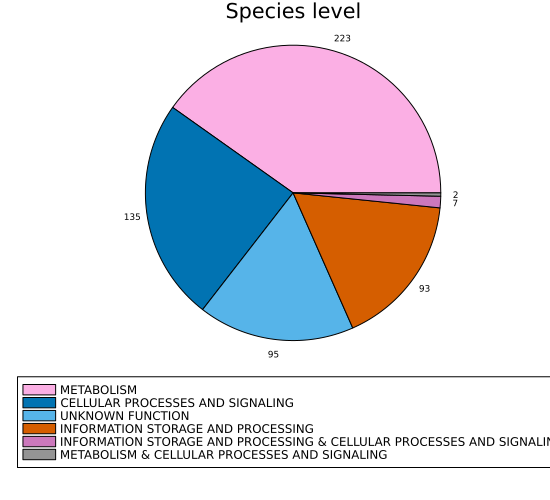

In [25]:
species_level_acetate_oggs =
    @chain sigtestresults begin
        subset(
            :nodeids => ByRow(∈(acetate_differences.nodeid)),
            :tree_level => ByRow(==("species level")),
        )
        # select([:nodeids, :grp1_N, :grp2_N, :ogg_name])
        select([:ogg_name])
        groupby(:ogg_name)
        combine(nrow)
        leftjoin(ogg_annotations, on=:ogg_name)
        unique
        # subset(:isannotated => ByRow(==(true)))
        sort([:nrow, :category, :ogg_name])
        # groupby([:nodeids])
        # combine(:isannotated => mean)
    end

labs, vals =
    @chain begin
        countmap(species_level_acetate_oggs.category_group)
        sort(byvalue=true, rev=true)
        (collect(keys(_)), collect(values(_)))
    end


pie(labs, vals,
    c=getindex.(Ref(colordict), labs),
    size=(550, 500),
    legend=:outerbottom,
    title="Species level",
)
thetas = 2pi * (cumsum(vals / sum(vals)) - ((vals / sum(vals)) / 2))
r = 1.1
annotate!(r * cos.(thetas), r * sin.(thetas), text.(string.(vals), 6))

In [26]:
savefig(joinpath(pdir, "acetate_species_level_ogg_category_groups.pdf"))

"/Users/bend/projects/Doran_etal_2023/plots/reviewer_plots/acetate_species_level_ogg_category_groups.pdf"

## All Metabolites

In [28]:
# get metabolite data
metabolite_names_full = biobank["metabolites_foldchange"].var.label;
bb_met_lfc = biobank["metabolites_foldchange"].X[:, :];

# filter to metaboltes with at least 10% measureable data
measurable_metabolites_mask = mapslices(c->mean(c .==0.) < .9, bb_met_lfc[biobank.obs.kept_species .== 1, :], dims=1)|>vec;
keepmetabolites_mask = measurable_metabolites_mask;
metabolite_names = metabolite_names_full[keepmetabolites_mask];
metabolite_label = biobank["metabolites_foldchange"].var.label[keepmetabolites_mask];
metabolite_ids = biobank["metabolites_foldchange"].var.ID[keepmetabolites_mask];

In [29]:
met_mtx = bb_met_lfc[:, keepmetabolites_mask]
met_ids = biobank.obs_names;
strvar_tree = readnw(open(readline, datadir("exp_pro","BB669","strvar-spitree.nw")));

In [32]:
# nodes where the average change in aceate is 2 times higher in one group vs the other
metabolite_differences =
    map(prewalk(strvar_tree)) do node
        (isleaf(node) || any(isleaf.(children(node)))) && return missing
        nodeid = id(node)
        g1 = met_mtx[indexin(getleafnames(node[1]), met_ids), :]
        g2 = met_mtx[indexin(getleafnames(node[2]), met_ids), :]
        effect = abs.(mean(g1, dims=1) .- mean(g2, dims=1))
        return (; nodeid, effect)
    end

threshold = 1 # 2-fold difference

node_selectors =
    @chain metabolite_differences begin
        skipmissing
        DataFrame
        transform(:effect => ByRow(x -> tuple((x .> threshold)...)) => "effect_" .* metabolite_ids)
        select(Not(:effect))
        getindex.(Ref(_.nodeid), eachcol(_)[2:end])
    end;

In [33]:
df =
    map(metabolite_label, node_selectors) do ml, ns
        @chain sigtestresults begin
            subset(:nodeids => ByRow(∈(ns)))
            select([:tree_level, :ogg_name])
            groupby([:tree_level, :ogg_name])
            combine(nrow)
            leftjoin(ogg_annotations, on=:ogg_name)
            unique
            sort([:nrow, :category, :ogg_name])
            insertcols(1, :metabolite_label => ml)
        end
    end |> x -> reduce(vcat, x)
pltdf =
    @chain df begin
        groupby([:metabolite_label, :tree_level, :category_group])
        combine(nrow)
        groupby([:metabolite_label, :tree_level])
        transform(
            :nrow => (x -> x ./ sum(x)) => :nrow_frac
        )
        groupby([:tree_level, :category_group])
        combine(
            :nrow_frac => mean,
            :nrow_frac => std,
            :nrow_frac => median,
            :nrow_frac => iqr,
        )
        sort([:tree_level, :nrow_frac_mean, :category_group])
    end

22×6 DataFrame
 Row │ tree_level     category_group                     nrow_frac_mean  nrow_ ⋯
     │ String15       String?                            Float64         Float ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │ phylum level   CELLULAR PROCESSES AND SIGNALING…      0.00240964    4.5 ⋯
   2 │ phylum level   INFORMATION STORAGE AND PROCESSI…      0.00481928    9.0
   3 │ phylum level   METABOLISM & INFORMATION STORAGE…      0.00722892    0.0
   4 │ phylum level   METABOLISM & CELLULAR PROCESSES …      0.0216867     0.0
   5 │ phylum level   INFORMATION STORAGE AND PROCESSI…      0.13253       2.9 ⋯
   6 │ phylum level   UNKNOWN FUNCTION                       0.161446      2.9
   7 │ phylum level   CELLULAR PROCESSES AND SIGNALING       0.306024      5.8
   8 │ phylum level   METABOLISM                             0.363855      5.8
  ⋮  │       ⋮                        ⋮                        ⋮               ⋱
  16 │ strain level   METABOLISM & CELLULAR PROCESSES …      0.00904381    0.0 ⋯
  17 │ strain level   INFORMATION STORAGE AND PROCESSI…      0.0102366     0.0
  18 │ strain level   METABOLISM & INFORMATION STORAGE…      0.0449953     0.0
  19 │ strain level   METABOLISM                             0.132385      0.0
  20 │ strain level   CELLULAR PROCESSES AND SIGNALING       0.198778      0.0 ⋯
  21 │ strain level   INFORMATION STORAGE AND PROCESSI…      0.248418      0.1
  22 │ strain level   UNKNOWN FUNCTION                       0.486934      0.1
                                                    3 columns and 7 rows omitted

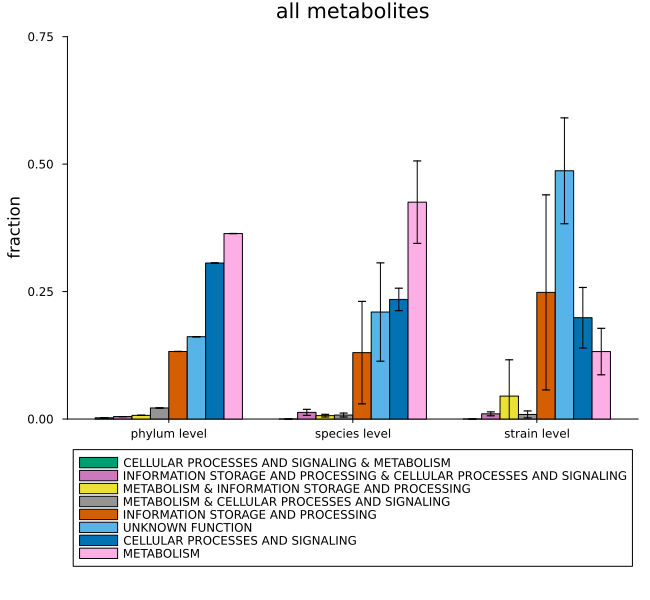

In [34]:
plt_labels = names(unstack(pltdf, :tree_level, :category_group, :nrow_frac_mean))[2:end]
x_labels = unique(pltdf.tree_level) |> sort
pltmtx_mean = Matrix(coalesce.(unstack(pltdf, :tree_level, :category_group, :nrow_frac_mean), 0.0)[:, 2:end])
pltmtx_std = Matrix(coalesce.(unstack(pltdf, :tree_level, :category_group, :nrow_frac_std), 0.0)[:, 2:end])
groupedbar(pltmtx_mean, 
    yerrorbar=pltmtx_std,
    label=permutedims(plt_labels),
    xticks = (1:3, x_labels),
    legend=:outerbottom,
    size=(650,600),
    ylims=(0, .75),
    c=getindex.(Ref(colordict), plt_labels) |> permutedims,
    ylabel="fraction",
    title="all metabolites",
    )

In [35]:
savefig(joinpath(pdir,"all_metabolites_groupedbar.pdf"))

"/Users/bend/projects/Doran_etal_2023/plots/reviewer_plots/all_metabolites_groupedbar.pdf"